In [7]:
!unzip data/fairface-img-margin025-trainval.zip -d data

Archive:  data/fairface-img-margin025-trainval.zip
   creating: train/
  inflating: train/1346.jpg          
  inflating: train/1498.jpg          
  inflating: train/4904.jpg          
  inflating: train/10734.jpg         
  inflating: train/36231.jpg         
  inflating: train/42641.jpg         
  inflating: train/46173.jpg         
  inflating: train/49036.jpg         
  inflating: train/49039.jpg         
  inflating: train/60572.jpg         
  inflating: train/63324.jpg         
  inflating: train/1016.jpg          
  inflating: train/1759.jpg          
  inflating: train/2805.jpg          
  inflating: train/13446.jpg         
  inflating: train/29789.jpg         
  inflating: train/50357.jpg         
  inflating: train/51957.jpg         
  inflating: train/53880.jpg         
  inflating: train/60583.jpg         
  inflating: train/61699.jpg         
  inflating: train/10476.jpg         
  inflating: train/26530.jpg         
  inflating: train/26549.jpg         
  inflating: trai

In [9]:
import torch
import numpy as np
import cv2
import pandas as pd
import glob, time
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from torch import optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import torchvision
from torchvision import transforms, models, datasets
import pandas as pd
from torch.utils.data import Dataset, DataLoader
import cv2
from torchvision.models import VGG16_Weights

%matplotlib inline
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [172]:
IMAGE_SIZE = 224


class GenderAgeDataset(Dataset):
    def __init__(self, df, tfms=None):
        self.df = df
        self.normalize = transforms.Normalize(
            mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]
        )

    def __len__(self):
        return len(self.df)

    def __getitem__(self, ix):
        f = self.df.iloc[ix].squeeze()
        file = f.file
        gen = f.gender == "Female"
        age = f.age
        im = cv2.imread("data/" + file)
        im = cv2.cvtColor(im, cv2.COLOR_BGR2RGB)
        return im, age, gen

    @staticmethod
    def preprocess_image(im):
        im = cv2.resize(im, (IMAGE_SIZE, IMAGE_SIZE))
        im = torch.tensor(im).permute(2, 0, 1)
        normalize = transforms.Normalize(
            mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]
        )
        im = normalize(im / 255.0)
        return im

    def collate_fn(self, batch):
        "preprocess images, ages and genders"
        ims, ages, genders = [], [], []
        for im, age, gender in batch:
            im = self.preprocess_image(im)
            ims.append(im.unsqueeze(0))

            ages.append(float(age) / 9)
            genders.append(float(gender))

        ages, genders = [torch.tensor(x).to(device).float() for x in [ages, genders]]

        ims = torch.cat(ims, dim=0).to(device)

        return ims, ages, genders


class AgeGenderClassifier(nn.Module):
    def __init__(self):
        super(AgeGenderClassifier, self).__init__()
        self.intermediate = nn.Sequential(
            nn.Linear(2048, 512),
            nn.ReLU(),
            nn.Dropout(0.4),
            nn.Linear(512, 128),
            nn.ReLU(),
            nn.Dropout(0.4),
            nn.Linear(128, 64),
            nn.ReLU(),
        )
        # 用于做年龄回归的层
        self.age_classifier = nn.Sequential(nn.Linear(64, 1), nn.Sigmoid())
        # 用于做性别分类的层
        self.gender_classifier = nn.Sequential(nn.Linear(64, 1), nn.Sigmoid())

    def forward(self, x):
        x = self.intermediate(x)
        age = self.age_classifier(x)
        gender = self.gender_classifier(x)
        return gender, age


def get_model():
    model = models.vgg16(weights=VGG16_Weights.IMAGENET1K_V1)

    for param in model.parameters():
        param.requires_grad = False

    model.avgpool = nn.Sequential(
        nn.Conv2d(512, 512, kernel_size=3), nn.MaxPool2d(2), nn.ReLU(), nn.Flatten()
    )

    model.classifier = AgeGenderClassifier()
    gender_loss_fn = nn.BCELoss()
    age_loss_fn = nn.L1Loss()
    loss_fns = gender_loss_fn, age_loss_fn
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

    return model.to(device), loss_fns, optimizer


def train_batch(data, model, optimizer, loss_fns):
    model.train()
    ims, age, gender = data
    optimizer.zero_grad()
    pred_gender, pred_age = model(ims)
    gender_loss_fn, age_loss_fn = loss_fns

    gender_loss = gender_loss_fn(pred_gender.squeeze(), gender)
    age_loss = age_loss_fn(pred_age.squeeze(), age)
    total_loss = gender_loss + age_loss

    total_loss.backward()
    optimizer.step()
    return total_loss


def validate_batch(data, model, loss_fns):
    model.eval()

    gender_loss_fn, age_loss_fn = loss_fns
    ims, age, gender = data

    with torch.no_grad():
        pred_gender, pred_age = model(ims)

    gender_loss = gender_loss_fn(pred_gender.squeeze(), gender)
    age_loss = age_loss_fn(pred_age.squeeze(), age)
    total_loss = gender_loss + age_loss

    pred_gender = (pred_gender > 0.5).squeeze()
    gender_acc = (pred_gender == gender).float().sum()
    age_mae = torch.abs(age - pred_age).float().sum()

    return total_loss, gender_acc, age_mae


age_mapping = {
    "0-2": 1,
    "3-9": 2,
    "10-19": 3,
    "20-29": 4,
    "30-39": 5,
    "40-49": 6,
    "50-59": 7,
    "60-69": 8,
    "more than 70": 9,
}

age_mapping_reverse = {
    1: "0-2",
    2: "3-9",
    3: "10-19",
    4: "20-29",
    5: "30-39",
    6: "40-49",
    7: "50-59",
    8: "60-69",
    9: "more than 70",
}

trn_df = pd.read_csv("data/fairface_label_train.csv")
val_df = pd.read_csv("data/fairface_label_val.csv")
trn_df["age"] = trn_df["age"].map(age_mapping)
val_df["age"] = val_df["age"].map(age_mapping)

trn = GenderAgeDataset(trn_df)
val = GenderAgeDataset(val_df)

train_loader = DataLoader(
    trn, batch_size=32, shuffle=True, drop_last=True, collate_fn=trn.collate_fn
)
test_loader = DataLoader(val, batch_size=32, collate_fn=val.collate_fn)

In [ ]:
model, loss_fns, optimizer = get_model()

In [173]:
val_gender_accuracies = []
val_age_maes = []
train_losses = []
val_losses = []

n_epochs = 5
best_test_loss = 1000

start = time.time()

for epoch in range(n_epochs):
    print(f"epoch: {epoch}")
    epoch_train_loss, epoch_test_loss = 0, 0
    val_age_mae, val_gender_acc, n_val = 0, 0, 0

    n_batch_train = len(train_loader)
    n_batch_val = len(test_loader)

    for idx, data in enumerate(train_loader):
        # test
        # if idx == 10:
        #     break

        if idx % 10 == 0:
            print(f"\ttraining: {idx}/{n_batch_train}")

        loss = train_batch(data, model, optimizer, loss_fns)
        epoch_train_loss += loss.item()

    for idx, data in enumerate(test_loader):
        # test
        if idx == 50:
            break

        if idx % 10 == 0:
            print(f"\tevaluating: {idx}/{n_batch_val}")

        loss, gender_acc, age_mae = validate_batch(data, model, loss_fns)
        epoch_test_loss += loss.item()
        val_age_mae += age_mae
        val_gender_acc += gender_acc
        n_val += len(data[1])

    val_age_mae /= n_val
    val_gender_acc /= n_val
    epoch_train_loss /= len(train_loader)
    epoch_test_loss /= len(test_loader)

    elapsed = time.time() - start
    best_test_loss = min(best_test_loss, epoch_test_loss)
    print(
        f"{epoch + 1}/{n_epochs} ({time.time() - start:.2f}s - {(n_epochs - epoch) * (elapsed / (epoch + 1)):.2f}s remaining)"
    )

    info = f"""Epoch: {epoch+1:03d}\tTrain Loss: {epoch_train_loss:.3f}\tTest: {epoch_test_loss:.3f}\tBest Test Loss: {best_test_loss:.4f}"""
    info += (
        f"\nGender Accuracy: {val_gender_acc*100:.2f}%\tAge MAE: {val_age_mae:.2f}\n"
    )
    print(info)

    val_gender_accuracies.append(val_gender_acc)
    val_age_maes.append(val_age_mae)

epoch: 0
	training: 0/2710
	training: 10/2710
	training: 20/2710
	training: 30/2710
	training: 40/2710
	training: 50/2710
	training: 60/2710
	training: 70/2710
	training: 80/2710
	training: 90/2710
	training: 100/2710
	training: 110/2710
	training: 120/2710
	training: 130/2710
	training: 140/2710
	training: 150/2710
	training: 160/2710
	training: 170/2710
	training: 180/2710
	training: 190/2710
	training: 200/2710
	training: 210/2710
	training: 220/2710
	training: 230/2710
	training: 240/2710
	training: 250/2710
	training: 260/2710
	training: 270/2710
	training: 280/2710
	training: 290/2710
	training: 300/2710
	training: 310/2710
	training: 320/2710
	training: 330/2710
	training: 340/2710
	training: 350/2710
	training: 360/2710
	training: 370/2710
	training: 380/2710
	training: 390/2710
	training: 400/2710
	training: 410/2710
	training: 420/2710
	training: 430/2710
	training: 440/2710
	training: 450/2710
	training: 460/2710
	training: 470/2710
	training: 480/2710
	training: 490/2710
	t

KeyboardInterrupt: 

In [144]:
data[0].shape

torch.Size([192, 224, 224])

predicted gender: Male ; Predicted age 10-19


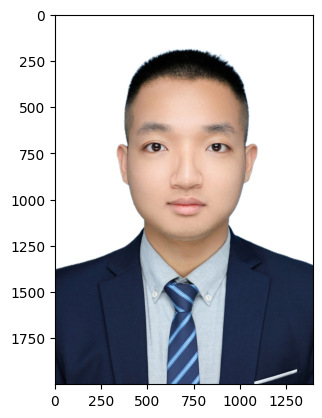

In [174]:
# img_path = "data/val/115.jpg"
img_path = "data/test_img.jpg"
im = cv2.imread(img_path)
im_preprocessed = GenderAgeDataset.preprocess_image(im).to(device)
im_preprocessed = im_preprocessed.unsqueeze(0)

gender, age = model(im_preprocessed)

pred_gender = gender.to("cpu").detach().numpy()
pred_gender = np.where(pred_gender[0][0] < 0.5, "Male", "Female")
pred_age = round(age.item() * 9)
pred_age = age_mapping_reverse[pred_age]

im = cv2.imread(img_path)
im = cv2.cvtColor(im, cv2.COLOR_BGR2RGB)

plt.imshow(im)
print(
    "predicted gender:",
    pred_gender,
    "; Predicted age",
    pred_age,
)

In [ ]:
pred_gender